In [1]:
import pandas as pd
import numpy as np 
import re 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pprint import pprint

# Using Wordnet for lemmatization
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

C:\Users\randy\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
df = pd.read_csv("../aftercovid.csv")
df.head()

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,26-Nov-20,A freehold semi-detached house at 61 Jalan Kel...,20,Nov,"['freehold', 'semi', 'detached', 'house', '61'...",freehold semi detached house 61 jalan kelawar ...,2020-11-26
1,23-Nov-20,"A 4,822 sq ft unit at luxury condo, Nassim Par...",20,Nov,"['4', '822', 'sq', 'ft', 'unit', 'luxury', 'na...",4 822 sq ft unit luxury nassim park residences...,2020-11-23
2,22-Nov-20,vinz said:\r\nWrote to HDB in OCT 2020 to get ...,20,Nov,"['vinz', 'wrote', 'hdb', 'oct', '2020', 'get',...",vinz wrote hdb oct 2020 get confirmation eligi...,2020-11-22
3,18-Nov-20,Wrote to HDB in OCT 2020 to get a confirmation...,20,Nov,"['wrote', 'hdb', 'oct', '2020', 'get', 'confir...",wrote hdb oct 2020 get confirmation eligibilit...,2020-11-18
4,29-Oct-20,Depends on if you need the space or not ?\r\nT...,20,Oct,"['depends', 'need', 'space', 'rules', 'changed...",depends need space rules changed last year usa...,2020-10-29


In [4]:
df['clean_text'].head()

0    ['freehold', 'semi', 'detached', 'house', '61'...
1    ['4', '822', 'sq', 'ft', 'unit', 'luxury', 'na...
2    ['vinz', 'wrote', 'hdb', 'oct', '2020', 'get',...
3    ['wrote', 'hdb', 'oct', '2020', 'get', 'confir...
4    ['depends', 'need', 'space', 'rules', 'changed...
Name: clean_text, dtype: object

In [5]:
len(df['clean_text'][0])

474

In [6]:
# remove punc 
df['clean_text']  = df['join_clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df['clean_text']  = df['clean_text'].apply(lambda x: x.lower())
# remove words with length < 2
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# tokenize
df['clean_text']  = [word_tokenize(row) for row in df['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use']
stop_words.extend(new_stop_words)

def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df['clean_text']  = df['clean_text'].apply(lambda x: remove_stopwords(x))

In [7]:
# lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['clean_text'] = df['clean_text'].apply(lemmatize_text)

In [8]:
from nltk.util import ngrams
def make_bigrams(texts):
    texts = ["_".join(w) for w in ngrams(texts, 2)]
    return texts

df['clean_text'] = df['clean_text'].apply(lambda x: make_bigrams(x))
df.head()

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,26-Nov-20,A freehold semi-detached house at 61 Jalan Kel...,20,Nov,"[freehold_semi, semi_detached, detached_house,...",freehold semi detached house 61 jalan kelawar ...,2020-11-26
1,23-Nov-20,"A 4,822 sq ft unit at luxury condo, Nassim Par...",20,Nov,"[822_unit, unit_luxury, luxury_nassim, nassim_...",4 822 sq ft unit luxury nassim park residences...,2020-11-23
2,22-Nov-20,vinz said:\r\nWrote to HDB in OCT 2020 to get ...,20,Nov,"[vinz_wrote, wrote_hdb, hdb_oct, oct_2020, 202...",vinz wrote hdb oct 2020 get confirmation eligi...,2020-11-22
3,18-Nov-20,Wrote to HDB in OCT 2020 to get a confirmation...,20,Nov,"[wrote_hdb, hdb_oct, oct_2020, 2020_get, get_c...",wrote hdb oct 2020 get confirmation eligibilit...,2020-11-18
4,29-Oct-20,Depends on if you need the space or not ?\r\nT...,20,Oct,"[depends_need, need_space, space_rule, rule_ch...",depends need space rules changed last year usa...,2020-10-29


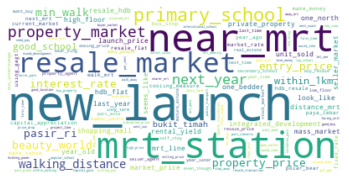

In [9]:
# Word Cloud

description_str = ''
for word_list in df['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '
    
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
# wordcloud.to_file("wordcloud_before_covid.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### LSA Topic Modelling

#### Prepare Corpus

In [10]:
# de-tokenization
detokenized_doc = df['clean_text'].tolist()

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(detokenized_doc)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = detokenized_doc
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, '100_nine'), (1, '500_psf'), (2, 'agent_sale'), (3, 'appointed_estate'), (4, 'arezone_utm'), (5, 'asking_price'), (6, 'campaign_forumposting'), (7, 'detached_house'), (8, 'edgeprop_property'), (9, 'estate_sole'), (10, 'frank_singapore'), (11, 'freehold_semi'), (12, 'frontage_jalan'), (13, 'house_jalan'), (14, 'house_sits'), (15, 'jalan_kelawar'), (16, 'kelawar_asking'), (17, 'kelawar_market'), (18, 'knight_frank'), (19, 'land_rate'), (20, 'market_million'), (21, 'marketing_agent'), (22, 'medium_utm'), (23, 'metre_frontage'), (24, 'million_knight'), (25, 'nine_metre'), (26, 'plot_100'), (27, 'price_translates'), (28, 'property_arezone'), (29, 'psf_edgeprop'), (30, 'rate_500'), (31, 'sale_two'), (32, 'semi_detached'), (33, 'singapore_appointed'), (34, 'sits_plot'), (35, 'sole_marketing'), (36, 'storey_house'), (37, 'translates_land'), (38, 'two_storey'), (39, 'utm_campaign'), (40, 'utm_medium'), (41, '822_unit'), (42, '899_psf'), (43, 'luxury_nassim'), (

#### Hyperparameter Tuning

#### Helpers

In [13]:
def prepare_corpus(doc_clean):

    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model

    return dictionary, doc_term_matrix

In [14]:
def create_gensim_lsa_model(doc_clean, number_of_topics, words):

    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix = prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics = number_of_topics, num_words = words))

    return lsamodel

In [15]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):

    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, chunksize = 100)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = doc_clean, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [17]:
def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    #plt.xlim([2, 20])
    plt.show()

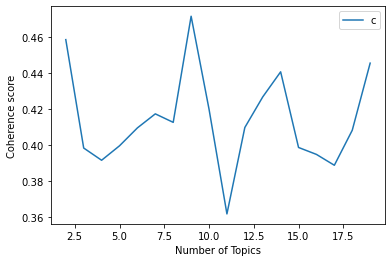

In [18]:
detokenized_doc = df['clean_text'].tolist()
start, stop, step = 2, 20, 1
plot_graph(detokenized_doc, start, stop, step)

### Building LSA Model 

In [19]:
number_of_topics = 9
words = 10
model = create_gensim_lsa_model(detokenized_doc, number_of_topics, words)

[(0, '0.352*"june_2020" + 0.254*"2020_cna" + 0.210*"new_launch" + 0.159*"jul_2020" + 0.151*"property_price" + 0.128*"may_2020" + 0.127*"cna_singapore" + 0.111*"channelnewsasia_new" + 0.100*"business_time" + 0.095*"2020_business"'), (1, '-0.720*"new_launch" + -0.168*"resale_market" + -0.143*"hdb_flat" + 0.135*"june_2020" + -0.107*"near_mrt" + 0.099*"2020_cna" + -0.096*"per_cent" + -0.086*"next_year" + -0.078*"mrt_station" + -0.077*"property_market"'), (2, '-0.426*"new_launch" + 0.401*"hdb_flat" + 0.311*"per_cent" + 0.092*"purchase_price" + 0.090*"hdb_resale" + 0.084*"cooling_measure" + 0.083*"property_market" + 0.069*"resale_flat" + 0.069*"mature_estate" + 0.066*"booking_fee"'), (3, '-0.416*"hdb_flat" + 0.313*"per_cent" + 0.108*"cooling_measure" + -0.099*"hdb_resale" + 0.095*"purchase_price" + 0.091*"property_market" + -0.086*"mature_estate" + -0.085*"resale_flat" + -0.081*"hdb_price" + -0.077*"market_rate"'), (4, '-0.549*"primary_school" + 0.180*"new_launch" + -0.155*"within_1km" + -0.

In [20]:
pprint(model.print_topics())

[(0,
  '0.352*"june_2020" + 0.254*"2020_cna" + 0.210*"new_launch" + '
  '0.159*"jul_2020" + 0.151*"property_price" + 0.128*"may_2020" + '
  '0.127*"cna_singapore" + 0.111*"channelnewsasia_new" + 0.100*"business_time" '
  '+ 0.095*"2020_business"'),
 (1,
  '-0.720*"new_launch" + -0.168*"resale_market" + -0.143*"hdb_flat" + '
  '0.135*"june_2020" + -0.107*"near_mrt" + 0.099*"2020_cna" + '
  '-0.096*"per_cent" + -0.086*"next_year" + -0.078*"mrt_station" + '
  '-0.077*"property_market"'),
 (2,
  '-0.426*"new_launch" + 0.401*"hdb_flat" + 0.311*"per_cent" + '
  '0.092*"purchase_price" + 0.090*"hdb_resale" + 0.084*"cooling_measure" + '
  '0.083*"property_market" + 0.069*"resale_flat" + 0.069*"mature_estate" + '
  '0.066*"booking_fee"'),
 (3,
  '-0.416*"hdb_flat" + 0.313*"per_cent" + 0.108*"cooling_measure" + '
  '-0.099*"hdb_resale" + 0.095*"purchase_price" + 0.091*"property_market" + '
  '-0.086*"mature_estate" + -0.085*"resale_flat" + -0.081*"hdb_price" + '
  '-0.077*"market_rate"'),
 (4,
 

In [21]:
coherence_model_lsa = CoherenceModel(model=model, texts=detokenized_doc, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.4744403334461455
